In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow.keras.preprocessing import image
import glob
import shutil
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, Input, Dense, Flatten, MaxPool2D, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import resnet50

In [3]:
train_data_path = "../input/fer2013/train" 
test_data_path =  "../input/fer2013/test"

### Creating Generators

In [4]:
def create_generator(batch_size, train_data_path, test_data_path):
    
    target_size=(48,48)
    
    train_preprocesser = ImageDataGenerator(
        rescale = 1/255.,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        validation_split=0.2
    )
    
    train_generator = train_preprocesser.flow_from_directory(
        train_data_path,
        class_mode = "categorical",
        target_size = target_size,
        shuffle = True,
        batch_size = batch_size,
        subset = "training"
    )
    
    val_generator = train_preprocesser.flow_from_directory(
        train_data_path,
        class_mode = "categorical",
        target_size = target_size,
        shuffle = True,
        batch_size = batch_size,
        subset = "validation"
    )
    
    test_preprocesser = ImageDataGenerator(rescale=1./255,
                                           width_shift_range=0.1,
                                           height_shift_range=0.1,
                                           horizontal_flip=True)
    
    test_generator = test_preprocesser.flow_from_directory(
        test_data_path,
        class_mode = "categorical",
        target_size=target_size,
        shuffle = True,
        batch_size = batch_size
    )
    
    return train_generator, val_generator, test_generator

In [5]:
batch_size = 32

train_generator, val_generator, test_generator = create_generator(batch_size, train_data_path, test_data_path)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [6]:
train_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

### ResNet Model

In [8]:
def ResNet(number_of_classes):
    
    model = models.Sequential()
    
    pretrained_model = resnet50.ResNet50(include_top=False, 
                                         weights='imagenet', 
                                         classes = number_of_classes, 
                                         input_shape=(48,48,3))
    
    pretrained_model.trainable = True
    
    model.add(pretrained_model)
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(BatchNormalization())

    model.add(Dense(256,activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01)))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(7, activation="softmax"))
    
    return model

In [10]:
number_of_classes = train_generator.num_classes
model_ResNet50 = ResNet(number_of_classes)
model_ResNet50.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 2, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8192)              32768     
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 64)               

In [11]:
epochs = 50

path_to_save_model_resnet = "resnet_model.h5"

ckpnt_saver = ModelCheckpoint(
    path_to_save_model_resnet,
    monitor = "val_accuracy",
    mode="max",
    save_best_only = True,
    save_freq = "epoch",
    verbose=1
    )

from tensorflow.keras.optimizers import Adam

model_ResNet50.compile(optimizer= Adam(1e-5),
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])

history_ResNet = model_ResNet50.fit(train_generator, 
                 epochs=epochs,
                 batch_size=32,
                 validation_data = val_generator,
                 callbacks = [ckpnt_saver]
                 )

2022-05-22 15:05:12.368111: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-05-22 15:05:17.973627: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


718/718 [==============================] - 160s 206ms/step - loss: 6.8775 - accuracy: 0.1659 - val_loss: 44.5152 - val_accuracy: 0.1756

Epoch 00001: val_accuracy improved from -inf to 0.17558, saving model to resnet_model.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
718/718 [==============================] - 56s 79ms/step - loss: 6.4737 - accuracy: 0.2313 - val_loss: 6.4195 - val_accuracy: 0.2585

Epoch 00002: val_accuracy improved from 0.17558 to 0.25849, saving model to resnet_model.h5
Epoch 3/50
718/718 [==============================] - 57s 80ms/step - loss: 6.1657 - accuracy: 0.2552 - val_loss: 6.2770 - val_accuracy: 0.2923

Epoch 00003: val_accuracy improved from 0.25849 to 0.29228, saving model to resnet_model.h5
Epoch 4/50
718/718 [==============================] - 59s 82ms/step - loss: 5.8702 - accuracy: 0.2782 - val_loss: 5.9189 - val_accuracy: 0.3231

Epoch 00004: val_accuracy improved from 0.29228 to 0.32311, saving model to resnet_model.h5
Epoch 5/50
718/718 [==============================] - 61s 85ms/step - loss: 5.5854 - accuracy: 0.3066 - val_loss: 5.6422 - val_accuracy: 0.3405

Epoch 00005: val_accuracy improved from 0.32311 to 0.34053, saving model to resnet_model.h5
Epoch 6/50
718/718 [==============================] 

In [12]:
print("Evaluating train set: ")
model_ResNet50.evaluate(train_generator)

print("Evaluating test set: ")
model_ResNet50.evaluate(test_generator)

Evaluating train set: 
718/718 [==============================] - 44s 61ms/step - loss: 1.0024 - accuracy: 0.7146
Evaluating test set: 
225/225 [==============================] - 42s 188ms/step - loss: 1.3402 - accuracy: 0.5893


[1.3401508331298828, 0.5893006324768066]

In [13]:
print(history_ResNet.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [14]:
def show_acc_and_loss(model):    
    plt.figure(figsize=(14,6))

    train_acc = model.history["accuracy"]
    train_loss = model.history["loss"]

    plt.subplot(1,2,1)
    plt.plot(model.history["accuracy"])
    plt.plot(model.history["val_accuracy"])
    plt.title("Train and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Train", "Validation"])

    plt.subplot(1,2,2)
    plt.plot(model.history["loss"])
    plt.plot(model.history["val_loss"])
    plt.title("Train and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Train", "Validation"])

    plt.show()

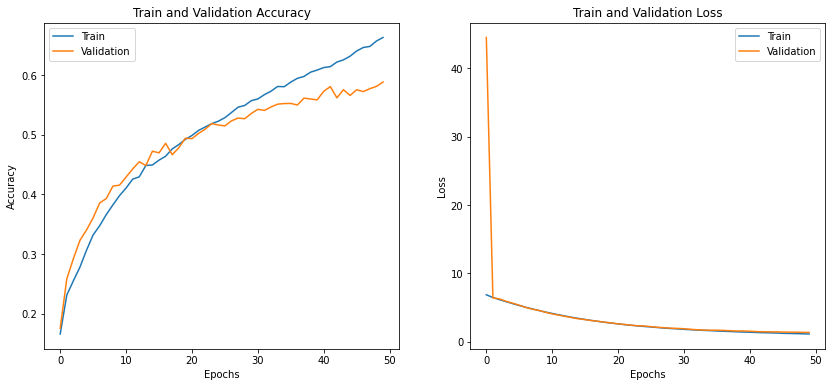

In [15]:
show_acc_and_loss(history_ResNet)

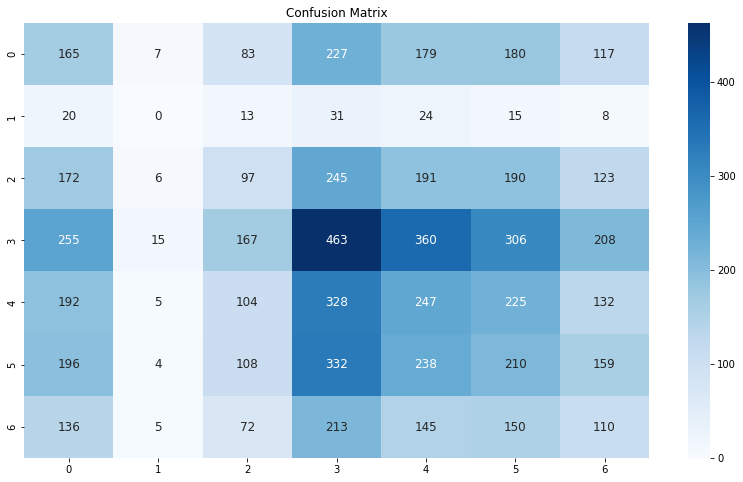

In [16]:
from sklearn.metrics import confusion_matrix


y_pred = model_ResNet50.predict(test_generator)
pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(test_generator.classes, pred)
plt.figure(figsize = (14,8))
plt.title("Confusion Matrix")

ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 12})